In [1]:
from constants import *
from utility_functions import *
from plot_functions import *
from decoding_approaches import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import vonmises, poisson
import math
from numpy.linalg import norm


In [2]:
# importlib module

#### This trajectory time is something that I am not sure how & where to use; Maybe T should be == num_positions ?

In [3]:
print('Time steps (s)')
# print('Spike count time window:',sc_time_step)
print('Unit time for OU process:',dt)

Time steps (s)
Unit time for OU process: 0.1


### Question about the plot 
Which of those time steps is better ? I would say the uncommented one, because indices represent points in time

Generating inputs

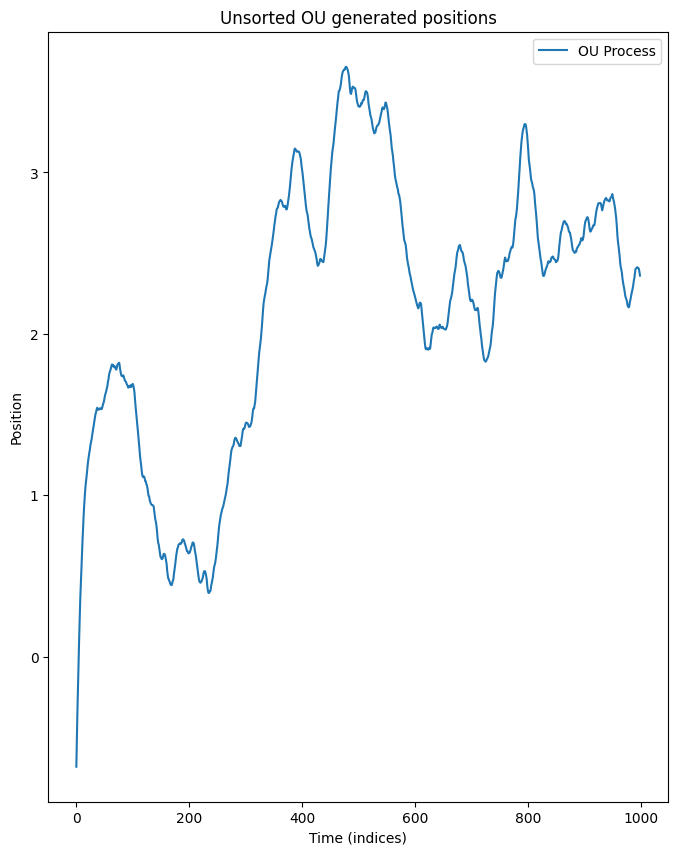

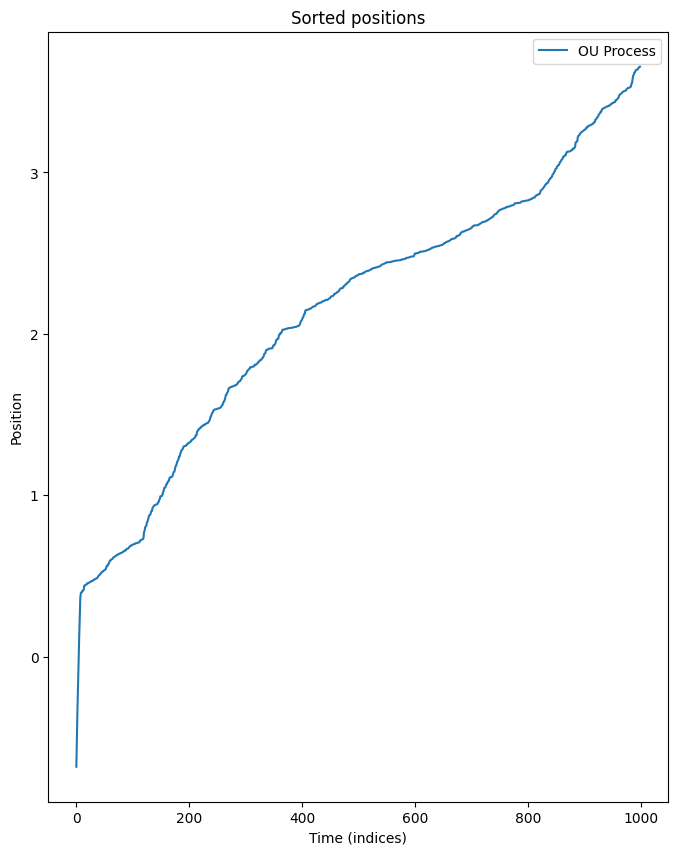

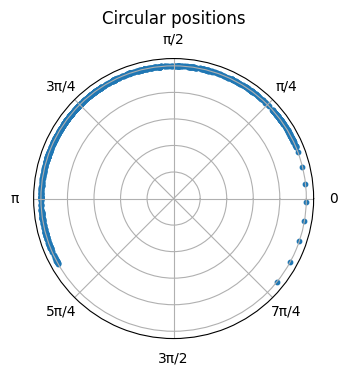

In [4]:
# OU process
#TODO: look @ the distribution of x (with same intial conditions) over 10^4 trials (it should be uniform)
x0 = np.random.randn()
v0 = np.random.randn()
positions, velocities = get_OU_inputs(x0, v0, num_positions, dt, tau, mu, sigma)  # ?? should I turn these to angular ?
plt_positions_uncirculated(positions, num_positions, dt, title='Unsorted OU generated positions')
# !!!!
srt_positions, velocities = zip(*sorted(zip(positions, velocities)))  # new velocities are just according to sorted positions
plt_positions_uncirculated(srt_positions, num_positions, dt, title='Sorted positions')

# Mapping positions on a circle
circ_positions = circular_positions(srt_positions, num_positions)
plt_circulated_pos(circ_positions)


In [ ]:
print(len(positions) == len(velocities))
print(velocities)

In [5]:
print(np.median(srt_positions))
print(np.mean(srt_positions))

2.363517275
2.14055332243


#### Phases

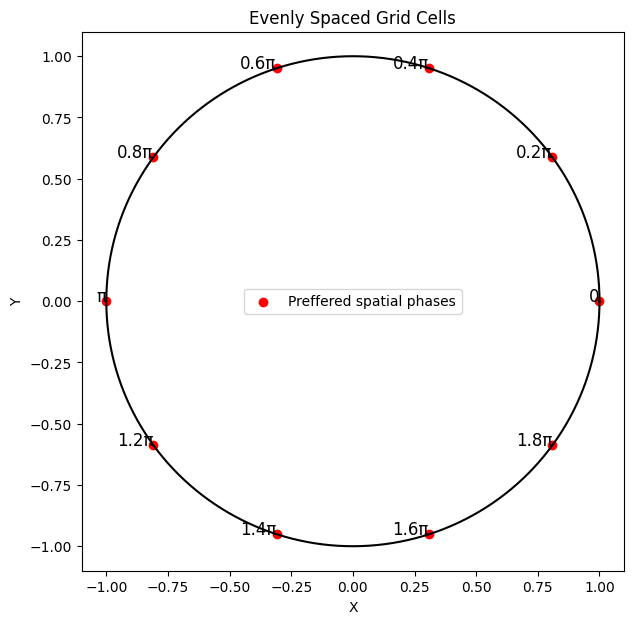

In [6]:
# Preffered phase of a grid cell
phases = get_evenly_spaced_phases(num_neurons, plot=True)

### Generating Firing rates

In [7]:
# For every neuron, for each position - a vector of spike rates is generated -- single number per position

# Comparing firing rates for circulated positions and uncirculated
firing_rates_p = np.zeros((num_neurons, num_positions))
firing_rates_cp = np.zeros((num_neurons, num_positions))

In [8]:
for pos in range(num_positions):
    firing_rates_p[:, pos] = compute_firing_rates_VM(srt_positions[pos], phases, scaling, kappa, max_firing_rate)
    firing_rates_cp[:, pos] = compute_firing_rates_VM(circ_positions[pos], phases, scaling, kappa, max_firing_rate)

------------------------------------------------------------------------------------------------------------------

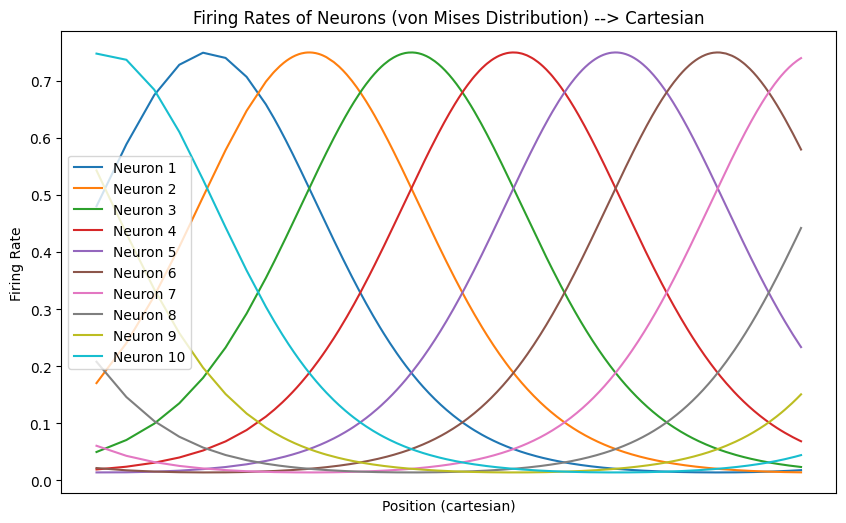

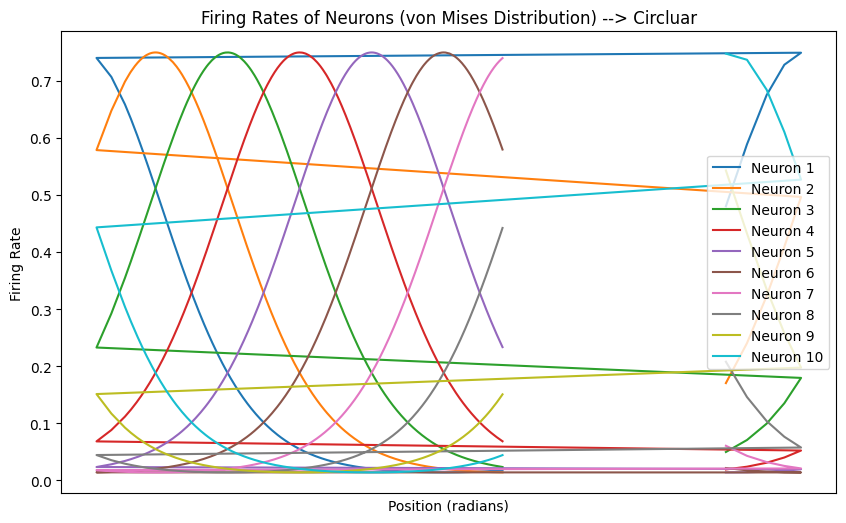

In [9]:
plt_firing_rates_VM(srt_positions, num_neurons, firing_rates_p, num_positions, title='Cartesian')
plt_firing_rates_VM(circ_positions, num_neurons, firing_rates_cp, num_positions, title='Circluar')

----------------------------------------------------------------------------------------------------------------

Vertical sum of firing rates is the same, that's why the vertical generation of spike counts doesn't make sense at all<br>I suppose the vertical firing rate sum is almost the same for every position, bc the positions are continuous<br>
Consequentially, the sum of spikes (generated vertically) will always be the same<br>
Also the spike vectors are completely the same so this cannot be the right approach


----------------------------------------------------------------------------------------------------------------

###  DECODING POSITIONS

Indices = time points<br>
Time window for counting spikes is 5 (so I take FIRST 5 succesive points for generating a FIRST count vector)

In [10]:
sc_time_step

5

In [11]:
# !! num_positions must be dividible w/ sc_time_step bc of reshaping the original_positions
num_time_windows = math.ceil(num_positions/sc_time_step)
spike_counts = np.zeros((num_time_windows, num_neurons))
fr_sums = np.zeros((num_time_windows, num_neurons))
decoded_positions = np.zeros(num_time_windows)
tw_original_positions = circ_positions.reshape(num_time_windows, -1)
aggregated_velocities = np.mean(velocities.reshape(-1, 5), axis=1)

In [12]:
for time_window in range(num_time_windows):
    for neuron in range(num_neurons):                                       # sliding through the positions
        fr_sums[time_window][neuron] = sum(firing_rates_cp[neuron][ time_window*sc_time_step : (time_window+1)*sc_time_step] )
        proba = np.random.random()
        spike_counts[time_window][neuron] = poisson.rvs(fr_sums[time_window][neuron], sc_time_step) if proba > dropout else 0

Pipline for every decoding approach <br>
1) approach_name<br>
2) for time_window: decoded_positions[time_window] = approach_algorithm(spike_counts[time_window])<br>
3) test_decoded_pos_rnd_index(tw_original_positions, decoded_positions, approach_name:str)<br>
4) mse, square_diff = MSE_decoded_original_pos(decoded_positions, original_positions)<br>
5) plt_square_diff(mse, squared_diff, approach_name:str, skip_ticks_step=10)<br>
6) plot_spike_count_statistics_vs_squared_diff(mse, squared_diff, approach_name:str, skip_ticks_step=10)  /    plt_scatter_sqd_sc(spike_counts, squared_diff)<br>
7) plt_circular_distance(decoded_positions, tw_original_positions, approach_name:str, skip_ticks_step=10)<br>
8) plt_real_vs_decoded_trajectory(decoded_positions, tw_original_positions, approach_name, sc_time_step=sc_time_step)<br>
9) plt_decoded_positions(tw_original_positions, decoded_positions, circ_positions, sc_time_step, num_time_windows_limit, tw_bounds:bool, approach_name:str)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#### Basic approach for decoding positions -- phase of the winner

In [13]:
approach_name = 'Basic'
decode_positions(decoded_positions, basic_approach, spike_counts, phases)

Random chosen tw: 87
Circ Mean original position for given tw (normalized radians): 2.2011448937868723
Decoded position (normalized radians): 2.5132741228718345


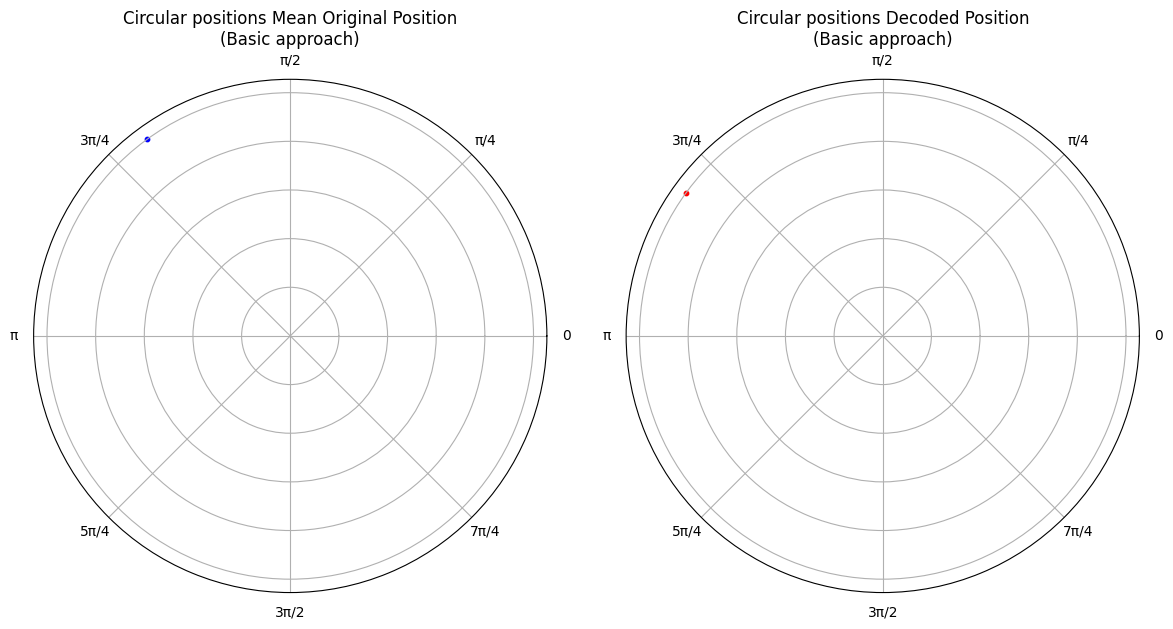

87

In [14]:
test_decoded_pos_rnd_index(tw_original_positions, decoded_positions, approach_name = approach_name)

In [15]:
# MSE
mse, squared_diff = MSE_decoded_original_pos(decoded_positions, tw_original_positions)

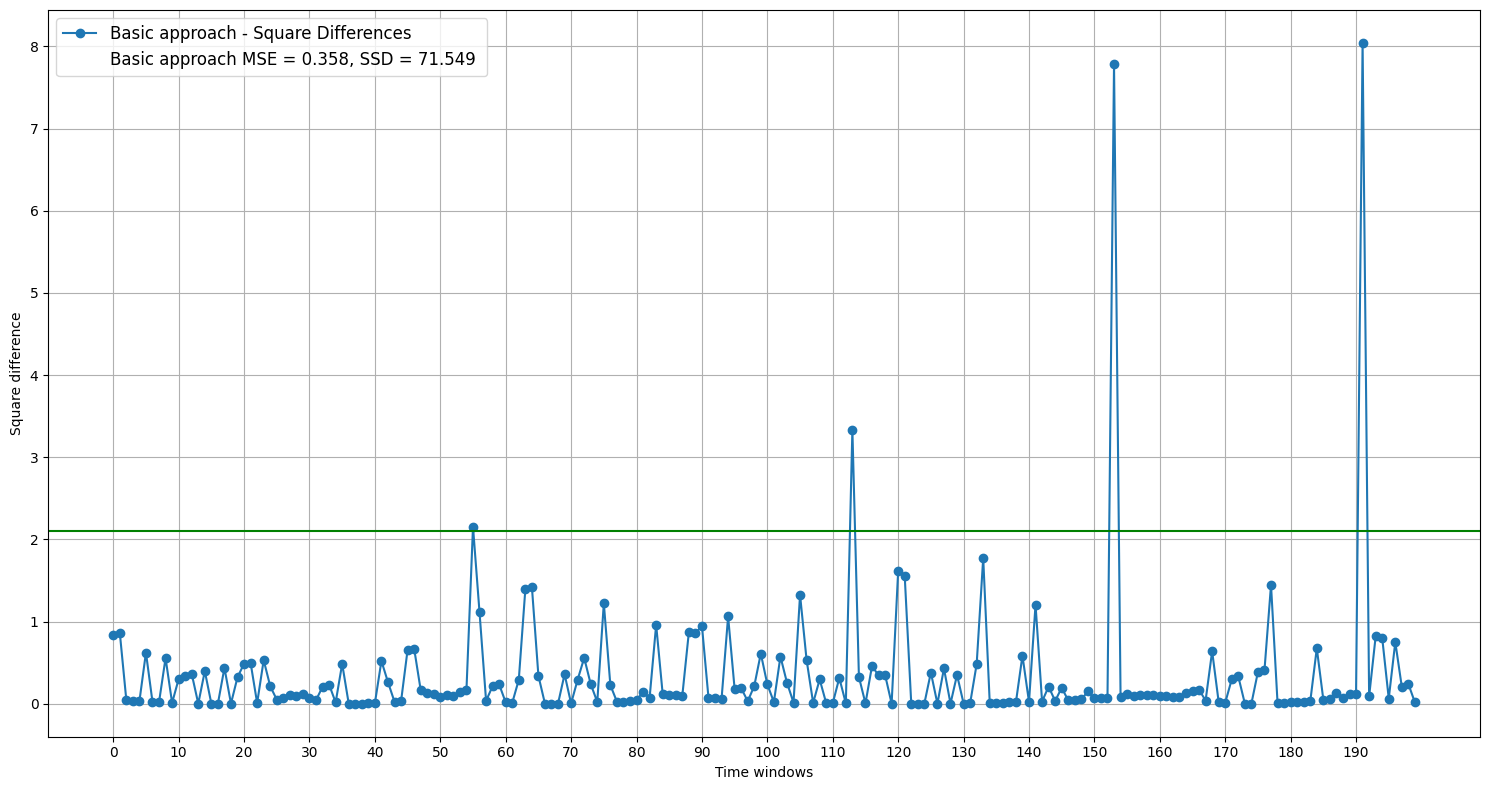

In [16]:
# def plt_square_diff(mse, squared_diff, approach_name:str, threshold_meth = 'min_max', k = None, skip_ticks_step=10):
plt_square_diff(mse, squared_diff, approach_name=approach_name, threshold_meth = 'mean_std', k=2)

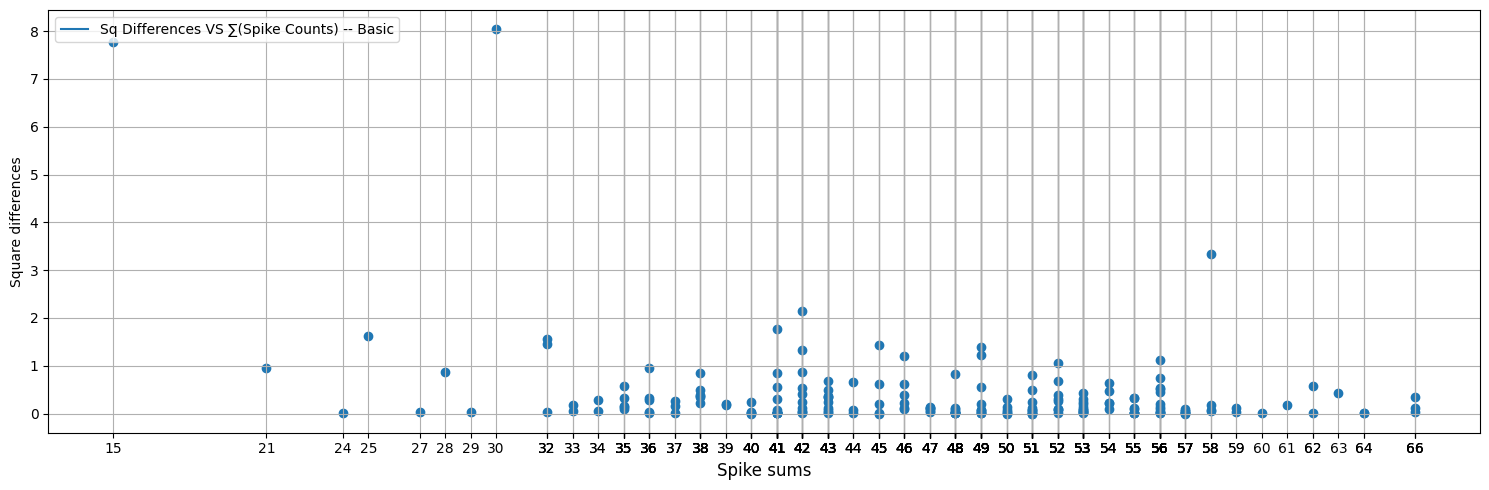

In [17]:
# plot_spike_count_statistics_vs_squared_diff(squared_diff, spike_counts, threshold_meth = 'mean_std', k = 2)
plt_scatter_sqd_sc(spike_counts, squared_diff, approach_name)

In [18]:
#TODO: this still doesn't fucking work !!!!
# plt_circular_distance(decoded_positions, tw_original_positions, approach_name)

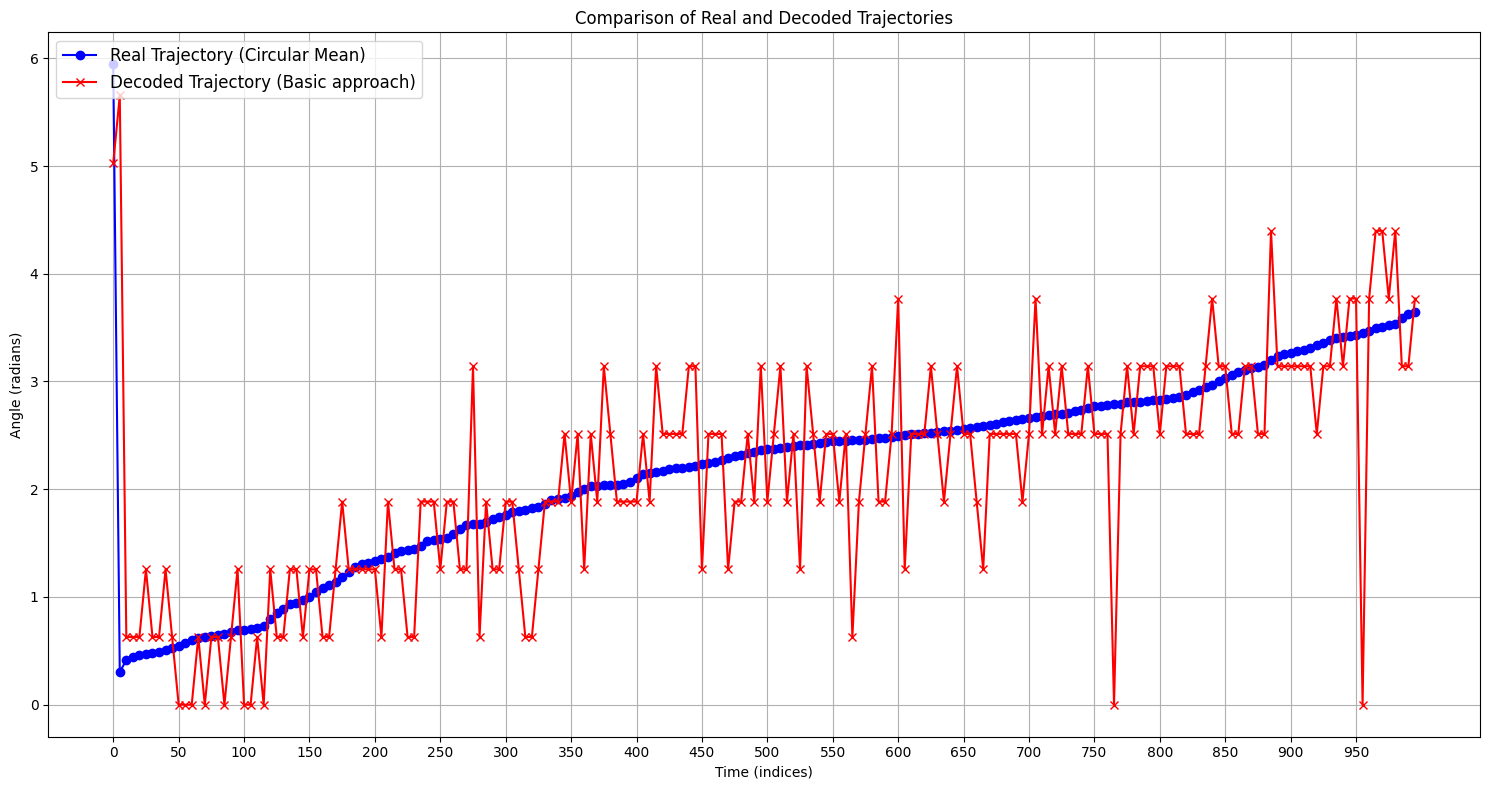

In [19]:
plt_real_vs_decoded_trajectory(decoded_positions, tw_original_positions, approach_name, skip_ticks_step=10)

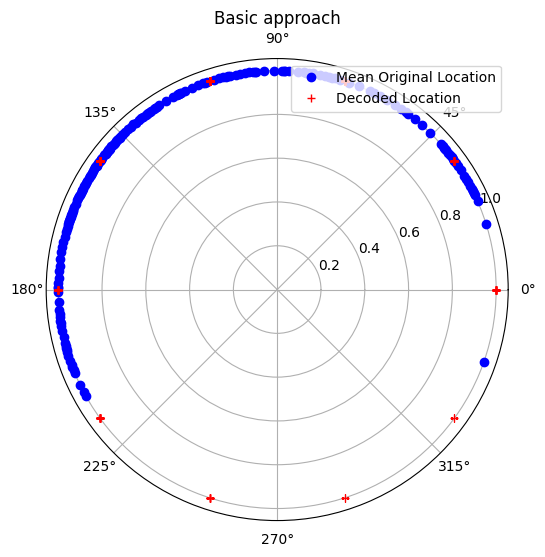

In [20]:
# num_tw_limit is how we make sure that decoded locations don't overlap
plt_decoded_positions_cmp_mean_og(tw_original_positions, decoded_positions, circ_positions, sc_time_step, num_time_windows_limit=num_time_windows, tw_bounds = False, approach_name=approach_name)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

## Approach2: Population Vector

Random chosen tw: 165
Circ Mean original position for given tw (normalized radians): 2.9012634576989758
Decoded position (normalized radians): 4.51763506219959


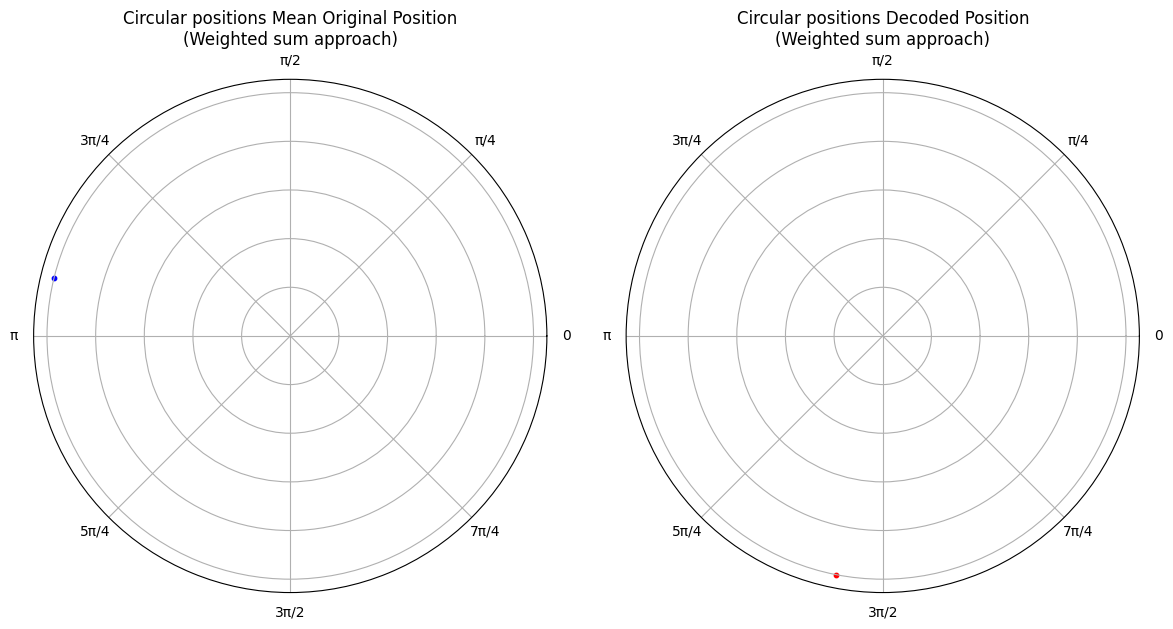

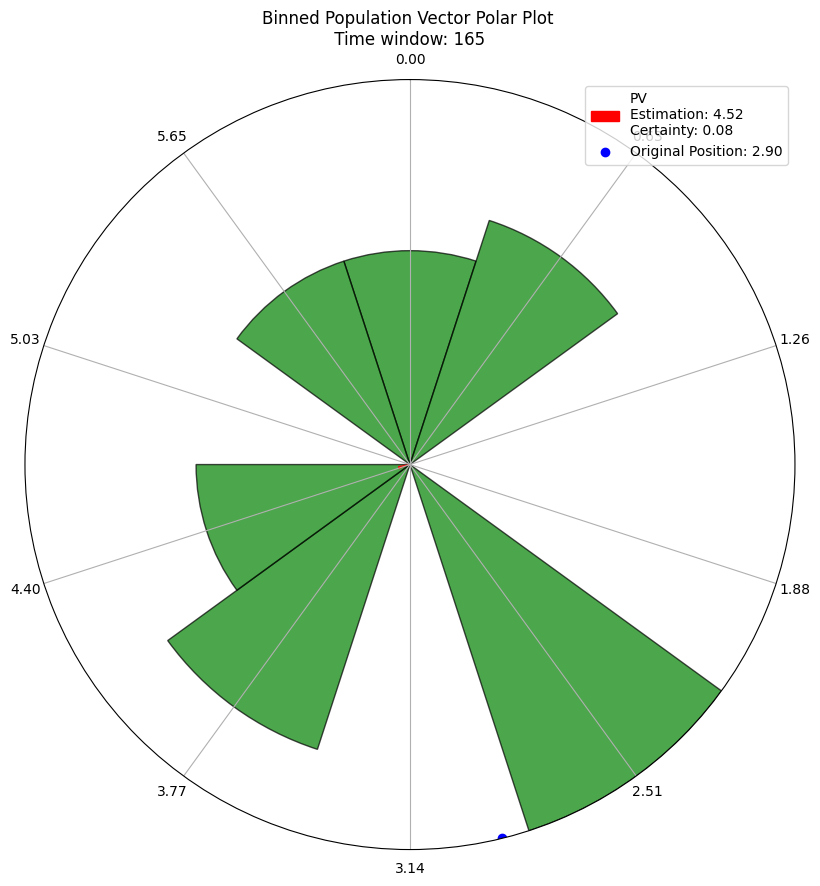

In [21]:
approach_name = 'Weighted sum'
pv_lengths = np.zeros(num_time_windows) # storing magnitudes of pv vector per time window 
decode_positions(decoded_positions, weighted_sum_approach, spike_counts, phases, pv_lengths) # for every time window I get a pv angle estimate, and pv certainty est

rnd_tw = test_decoded_pos_rnd_index(tw_original_positions, decoded_positions, approach_name = approach_name)
plot_binned_polar_population_vector(rnd_tw, spike_counts, decoded_positions, pv_lengths, tw_original_positions, phases)

### TEST: max spike counts VS max certainty

Max spike count: 16.0
spike_counts[142]: [ 0.  5.  0.  7. 16. 11.  5.  0.  6.  0.]
Ceratinty [142]: 0.5274318533104456


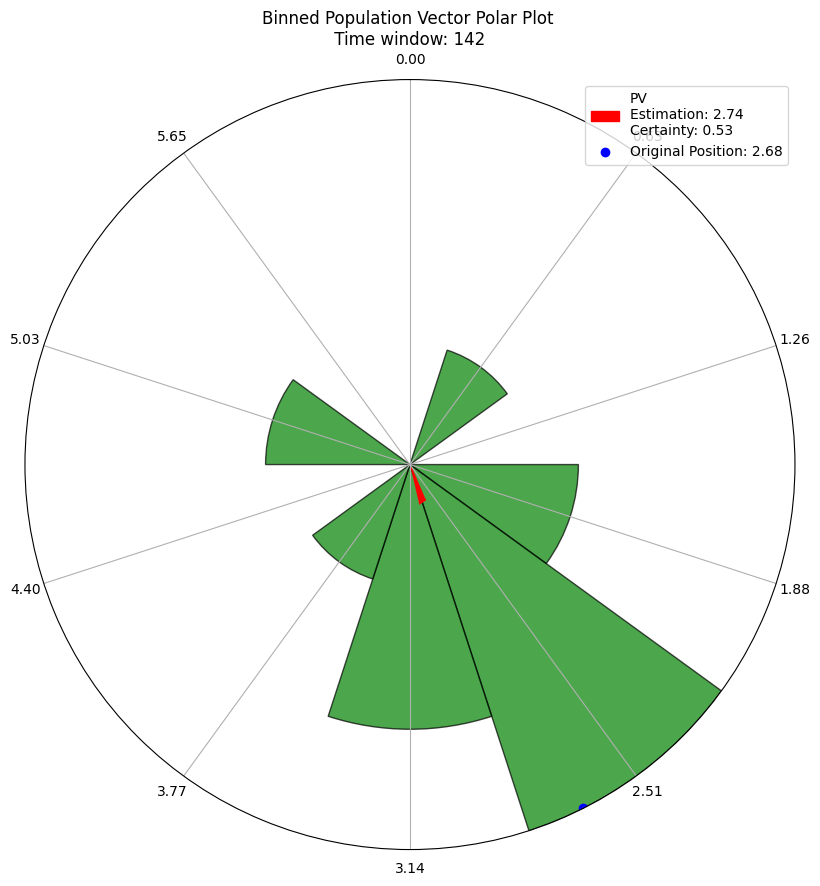

In [22]:
idx = int(np.argmax(spike_counts) / 10)
print(f'Max spike count: {np.max(spike_counts)}')
print(f'spike_counts[{idx}]: {spike_counts[idx]}')
print(f'Ceratinty [{idx}]: {pv_lengths[idx]}')
plot_binned_polar_population_vector(idx, spike_counts, decoded_positions, pv_lengths, tw_original_positions, phases)

Max certainty: 0.8726779962499649
spike counts [153]: [5. 0. 0. 0. 0. 0. 0. 0. 5. 5.]


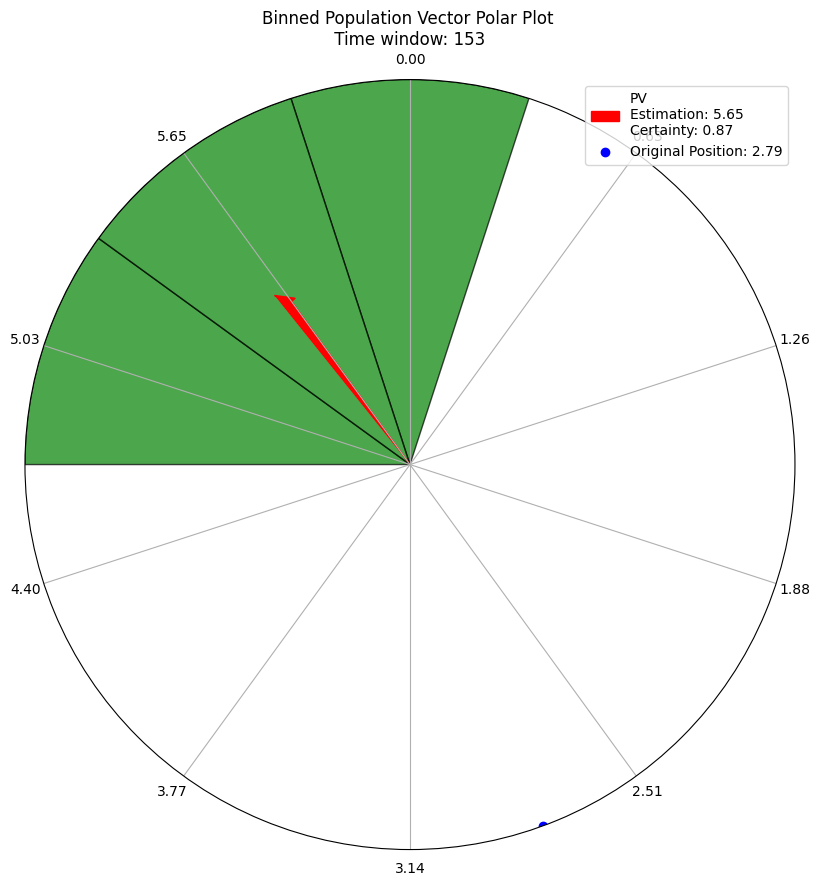

In [23]:
idx = np.argmax(pv_lengths)
print(f'Max certainty: {np.max(pv_lengths)}')
print(f'spike counts [{idx}]: {spike_counts[idx]}')
plot_binned_polar_population_vector(idx, spike_counts, decoded_positions, pv_lengths, tw_original_positions, phases)

#### Additional tests: variance between decoded/true velocities and decoded/true positions

In [ ]:
pv_estimated_velocities = pv_estim_vels(decoded_positions)
len(pv_estim_vels)

In [ ]:
plt_pv_cos_sim_vel(pv_estimated_velocities, aggregated_velocities)

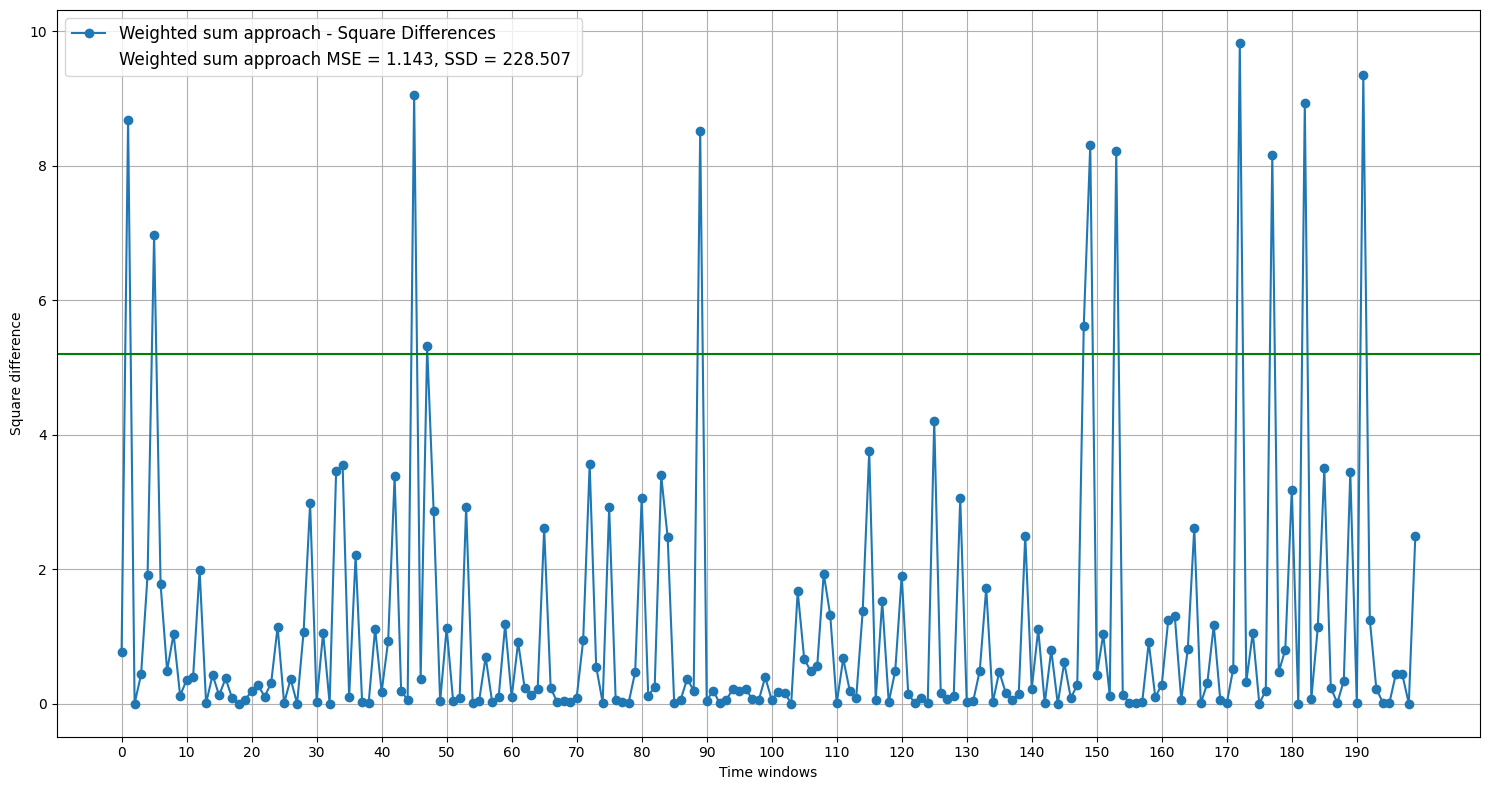

In [25]:
mse, squared_diff = MSE_decoded_original_pos(decoded_positions, tw_original_positions)
plt_square_diff(mse, squared_diff, approach_name=approach_name, threshold_meth = 'mean_std', k=2)

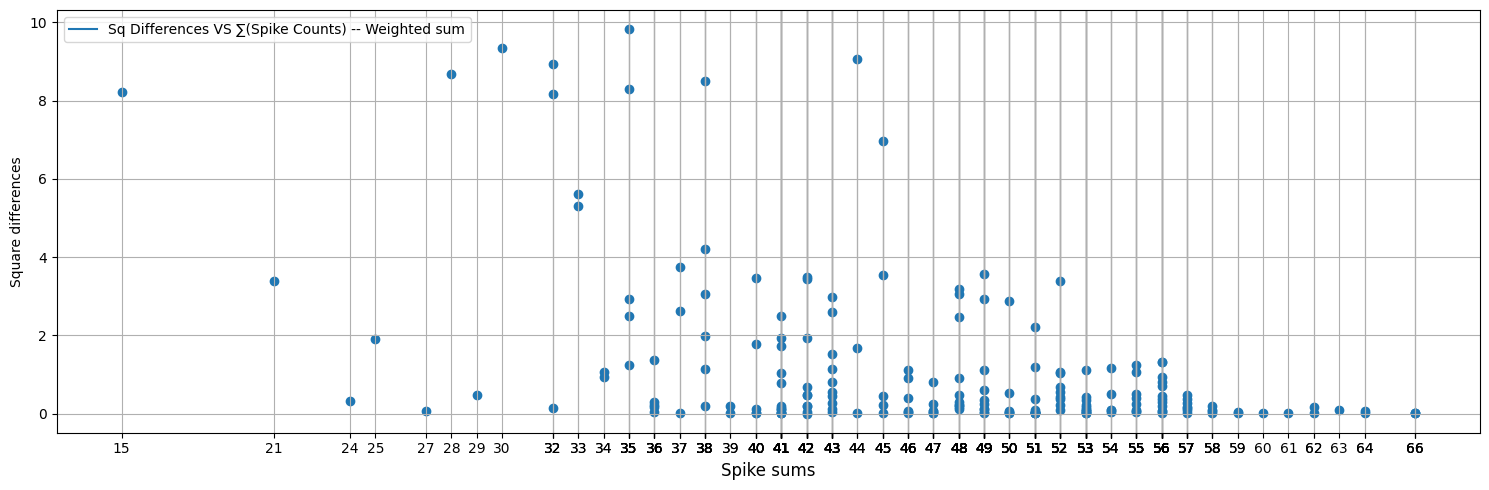

In [26]:
# plot_spike_count_statistics_vs_squared_diff(squared_diff, spike_counts, threshold_meth = 'mean_std', k = 2)
plt_scatter_sqd_sc(spike_counts, squared_diff, approach_name)

In [27]:
# plt_circular_distance(decoded_positions, tw_original_positions, approach_name)

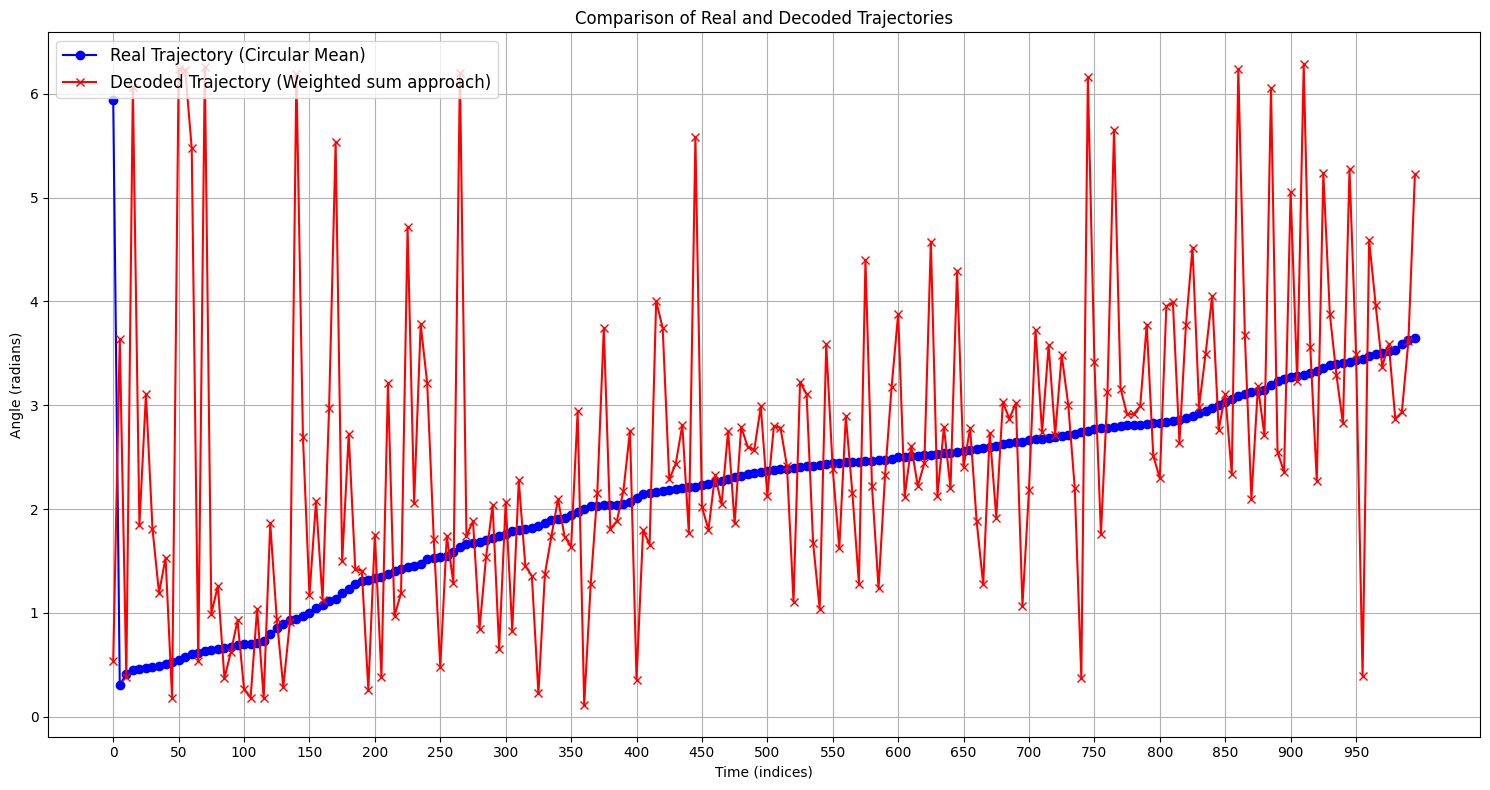

In [28]:
plt_real_vs_decoded_trajectory(decoded_positions, tw_original_positions, approach_name, skip_ticks_step=10)

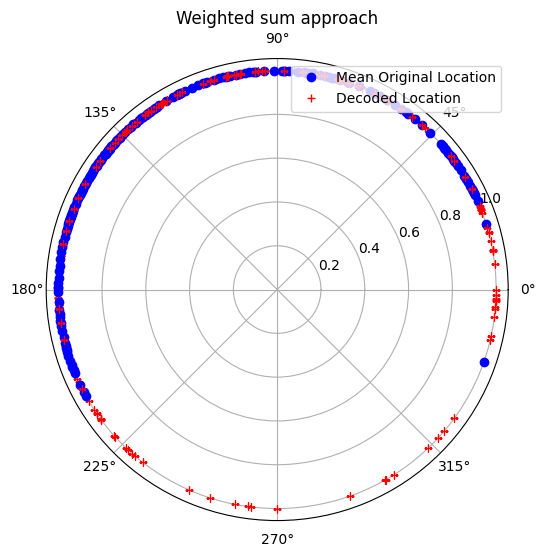

In [29]:
plt_decoded_positions_cmp_mean_og(tw_original_positions, decoded_positions, circ_positions, sc_time_step, num_time_windows_limit=num_time_windows, tw_bounds = False, approach_name=approach_name)

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#### Approach 3: MLE of position given observed spike counts -- Best for now

Pipline for every decoding approach <br>
1) approach_name<br>
2) for time_window: decoded_positions[time_window] = approach_algorithm(spike_counts[time_window])<br>
3) test_decoded_pos_rnd_index(tw_original_positions, decoded_positions, approach_name:str)<br>
4) mse, square_diff = MSE_decoded_original_pos(decoded_positions, original_positions)<br>
5) plt_square_diff(mse, squared_diff, approach_name:str, skip_ticks_step=10)<br>
6) plt_decoded_positions(tw_original_positions, decoded_positions, circ_positions, sc_time_step, num_time_windows_limit, tw_bounds:bool, approach_name:str)

In [30]:
approach_name = 'MLE'
decode_positions(decoded_positions, mle_approach, spike_counts, phases, tw_original_positions, positions, firing_rates_p)

Random chosen tw: 158
Circ Mean original position for given tw (normalized radians): 2.8214772080304984
Decoded position (normalized radians): 2.82027064


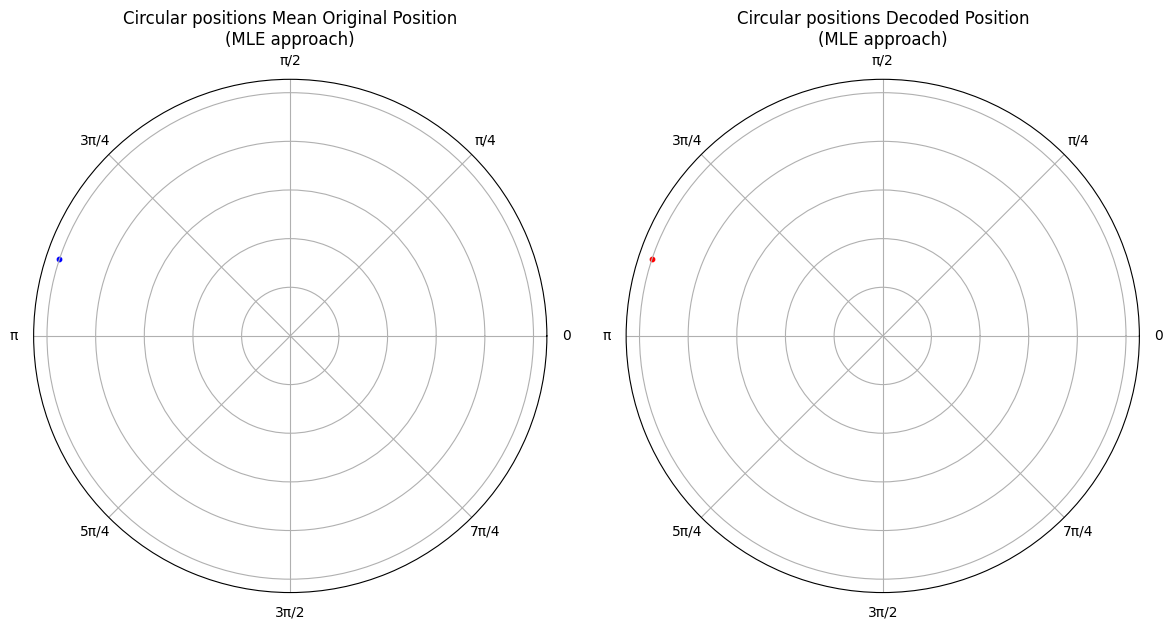

158

In [31]:
test_decoded_pos_rnd_index(tw_original_positions, decoded_positions, approach_name = approach_name)

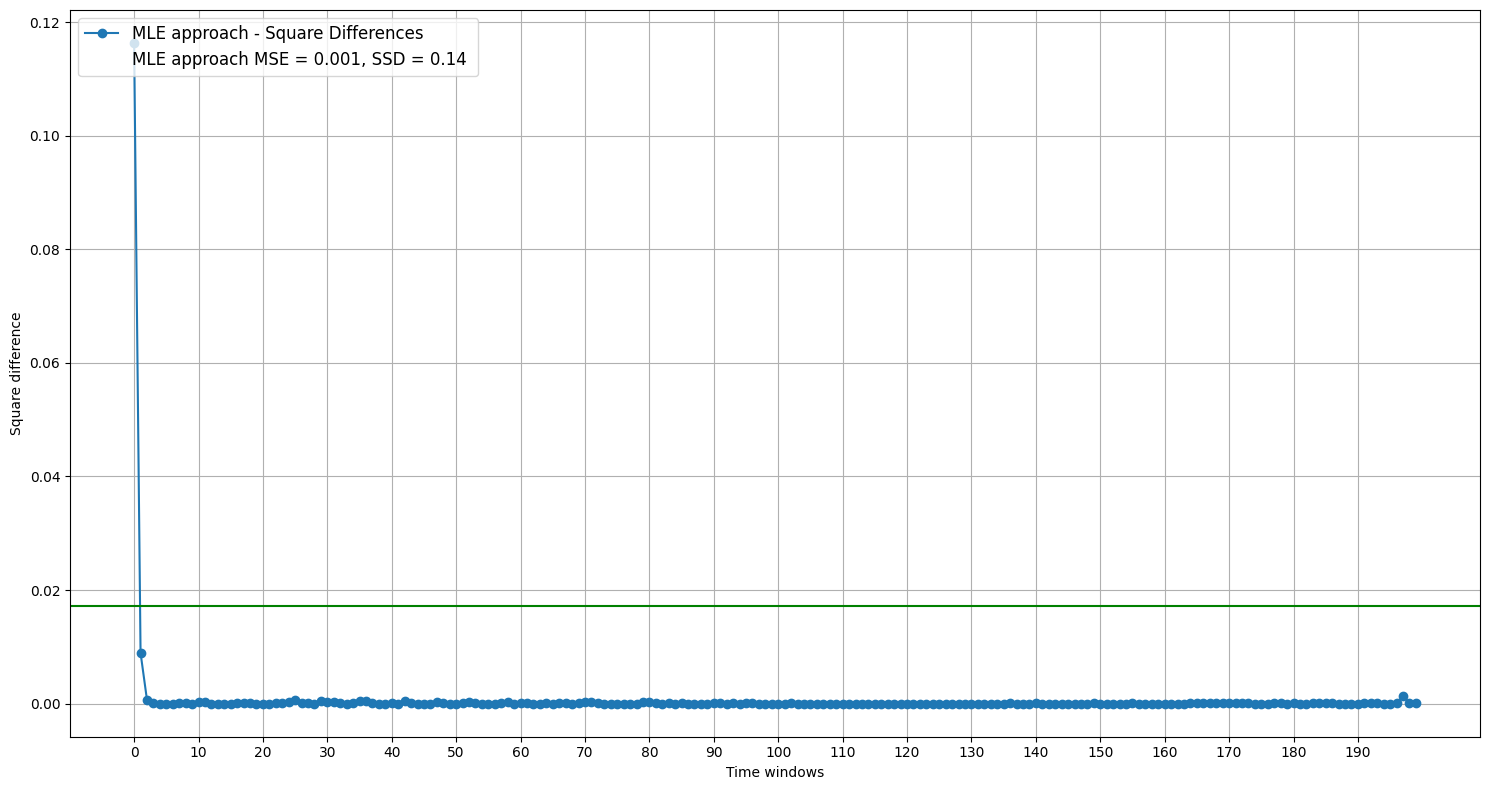

In [32]:
mse, squared_diff = MSE_decoded_original_pos(decoded_positions, tw_original_positions)
plt_square_diff(mse, squared_diff, approach_name=approach_name, threshold_meth = 'mean_std', k=2)

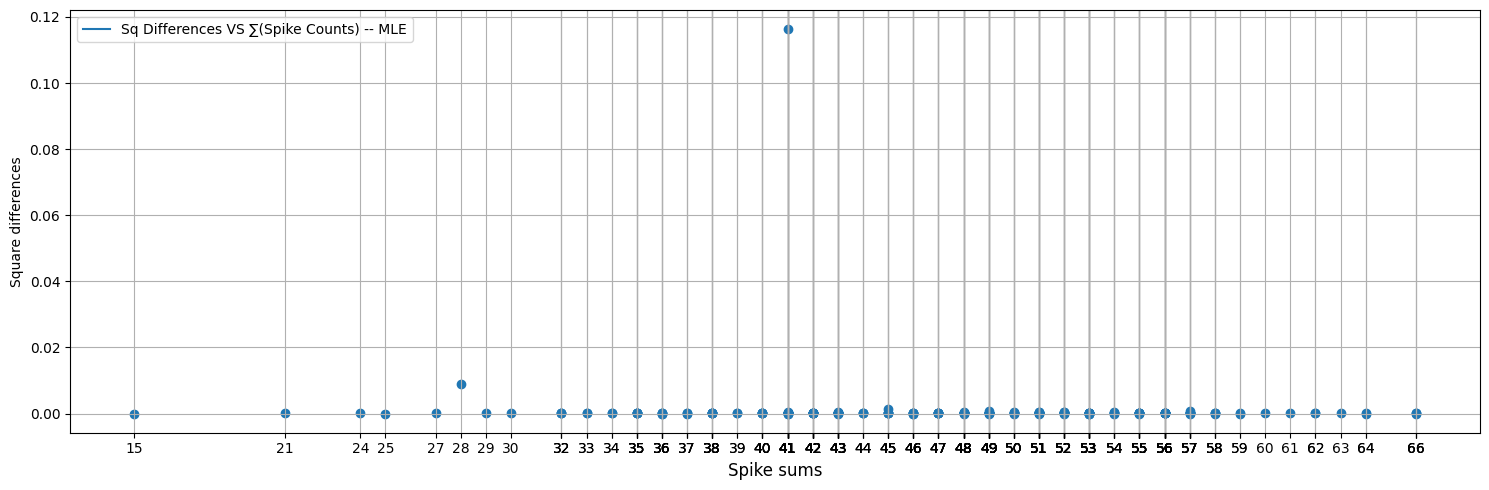

In [33]:
# plot_spike_count_statistics_vs_squared_diff(squared_diff, spike_counts, threshold_meth = 'mean_std', k = 2)
plt_scatter_sqd_sc(spike_counts, squared_diff, approach_name)

In [34]:
# plt_circular_distance(decoded_positions, tw_original_positions, approach_name)

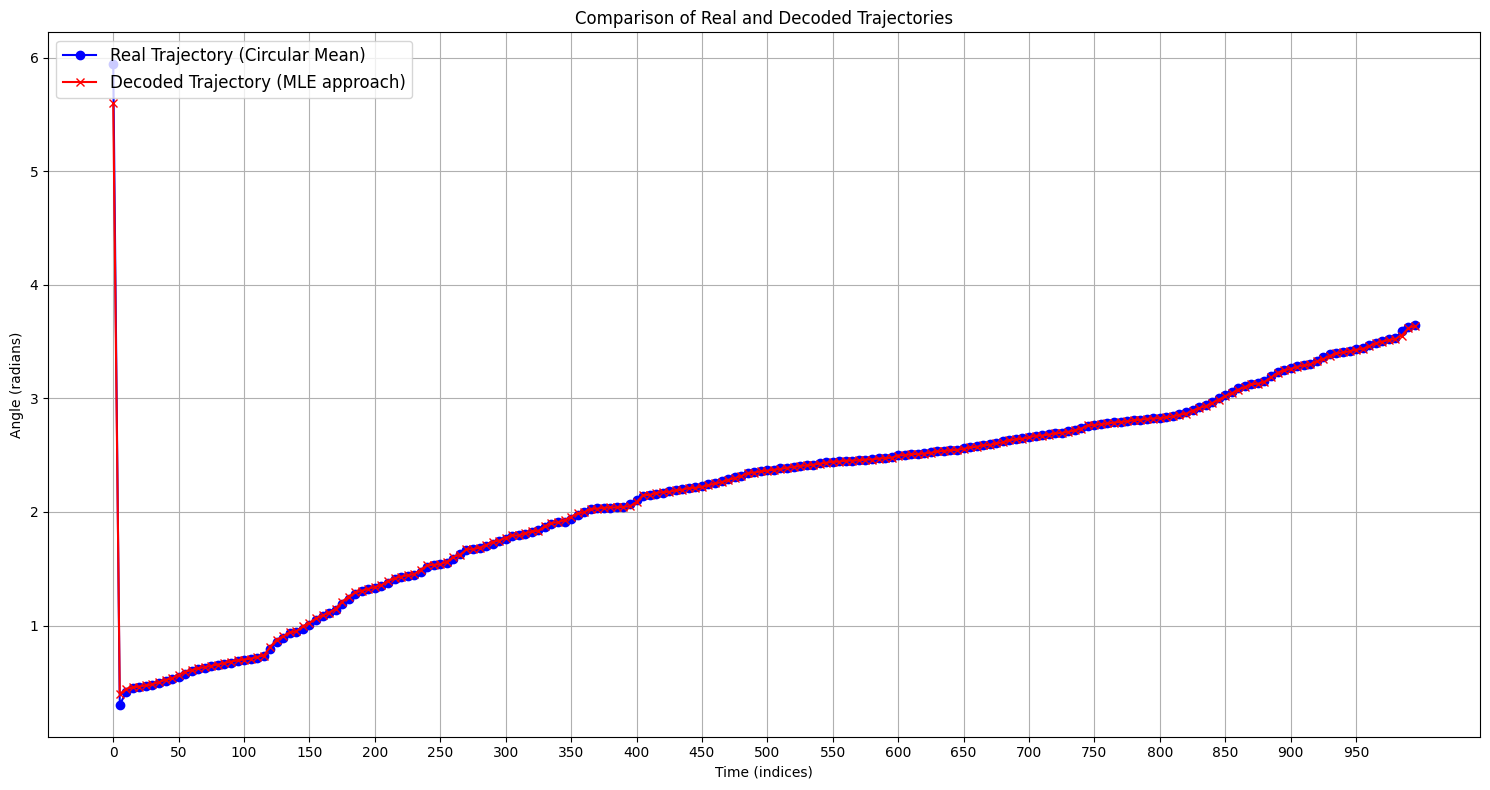

In [35]:
plt_real_vs_decoded_trajectory(decoded_positions, tw_original_positions, approach_name, skip_ticks_step=10)

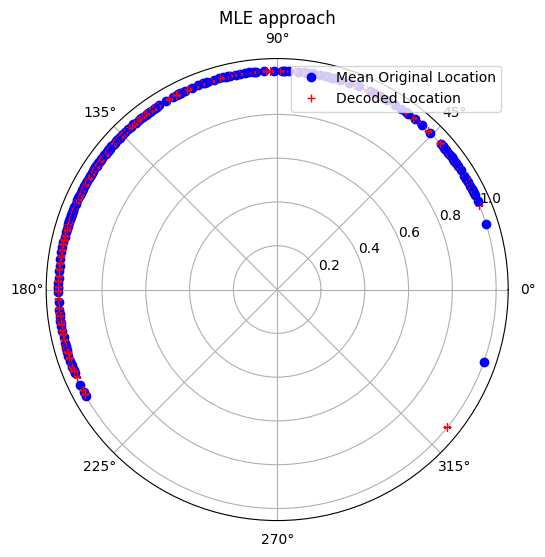

In [36]:
plt_decoded_positions_cmp_mean_og(tw_original_positions, decoded_positions, circ_positions, sc_time_step, num_time_windows_limit=num_time_windows, tw_bounds = False, approach_name=approach_name)

In [37]:
# np.eventplot -- for spike trains

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#### Approach 4: KF basic
Pipline for every decoding approach <br>
1) approach_name<br>
2) for time_window: decoded_positions[time_window] = approach_algorithm(spike_counts[time_window])<br>
3) test_decoded_pos_rnd_index(tw_original_positions, decoded_positions, approach_name:str)<br>
4) mse, square_diff = MSE_decoded_original_pos(decoded_positions, original_positions)<br>
5) plt_square_diff(mse, squared_diff, approach_name:str, skip_ticks_step=10)<br>
6) plt_decoded_positions(tw_original_positions, decoded_positions, circ_positions, sc_time_step, num_time_windows_limit, tw_bounds:bool, approach_name:str)

In [ ]:
approach_name = 'KF'
decode_positions(decoded_positions, mle_approach, spike_counts, phases, tw_original_positions, positions, firing_rates_p)

In [ ]:
# !! not using sorted pos
usrt_circ_positions = circular_positions(positions, num_positions)

x_0 = np.array([usrt_circ_positions[0], velocities[0]])